## Generative Adversarial Nets


项目地址见：<a href='https://github.com/ericjang/genadv_tutorial/blob/master/genadv1.ipynb'>Github</a>。训练一个GAN网络来从高斯分布中采样。

下述首先定义需要拟合的高斯分布。

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # for pretty plots 
from scipy.stats import norm 
%matplotlib inline

目标数据分布为 $p_{data}$。

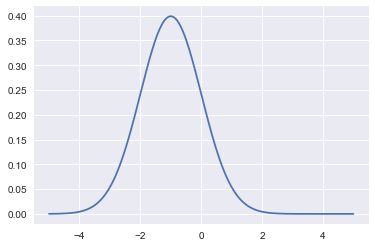

In [2]:
mu, sigma = -1, 1 
xs = np.linspace(-5, 5, 1000)
plt.plot(xs, norm.pdf(xs, loc=mu, scale=sigma))

In [3]:
TRAIN_ITERS = 10000 
M = 200  # mini-batch size
# 定义网络结构：最大似然推断


def mlp(input_tensor, output_dim):
    # construct learn-able parameters within local scope
    w1 = tf.get_variable("w0", [input_tensor.get_shape()[1], 6],
                         initializer=tf.random_normal_initializer())
    b1 = tf.get_variable("b0", [6], initializer=tf.constant_initializer(0.0))
    w2 = tf.get_variable("w1", [6, 5], 
                         initializer=tf.random_normal_initializer())
    b2 = tf.get_variable("b1", [5], initializer=tf.constant_initializer(0.0))
    w3 = tf.get_variable("w2", [5, output_dim], 
                         initializer=tf.random_normal_initializer())
    b3 = tf.get_variable("b2", [output_dim], initializer=tf.constant_initializer())
    # nn operators
    fc1 = tf.nn.tanh(tf.matmul(input_tensor, w1) + b1)
    fc2 = tf.nn.tanh(tf.matmul(fc1, w2)+b2)
    fc3 = tf.nn.tanh(tf.matmul(fc2, w3)+b3)
    return fc3, [w1, b1, w2, b2, w3, b3]

In [4]:
# re-used for optimizing all networks
# 定义优化计算图


def momentum_optimizer(loss, var_list):
    batch = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        0.001,  # base learning_rate
        batch,  # Current index into the database
        TRAIN_ITERS // 4,  # Decay step - this decayed 4 times throughout training process
        0.95,  # decay rate
        staircase=True)
    optimizer = tf.train.MomentumOptimizer(learning_rate, 0.6).\
        minimize(loss, global_step=batch, var_list=var_list)
    return optimizer

## Pre-Train Decision Surface
如果鉴别器可以以合理的精度开始，模型可以更快地收敛。这里预先训练了一个鉴别器，并保存了其参数，然后关闭会话，等待正式的网络使用。

In [5]:
with tf.variable_scope("D_pre_1"):
    input_node = tf.placeholder(tf.float32, shape=(M, 1))
    train_labels = tf.placeholder(tf.float32, shape=(M, 1))
    D, theta = mlp(input_node, 1)
    loss = tf.reduce_mean(tf.square(D-train_labels))

In [6]:
optimizer = momentum_optimizer(loss, None)
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [7]:
# plot decision surface
def plot_d0(D, input_node):
    f, ax = plt.subplots(1)
    # p_data
    xs = np.linspace(-5, 5, 1000)
    ax.plot(xs, norm.pdf(xs, loc=mu, scale=sigma), label="p_data")  
    # decision boundary
    r = 1000  # resolution (number of points)
    xs = np.linspace(-5, 5, r) 
    ds = np.zeros((r, 1))  # decision surface
    # process multiple points in parallel in a mini-batch
    for i in range(int(r/M)):
        x = np.reshape(xs[M*i:M*(i+1)], (M, 1))
        ds[M*i: M*(i+1)] = sess.run(D, {input_node: x})
    ax.plot(xs, ds, label="decision boundary")
    ax.set_ylim(0, 1.1)
    plt.legend()

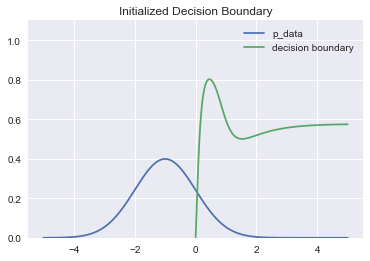

In [9]:
# 绘制出随机初始化参数时的决策面
plot_d0(D, input_node)
plt.title("Initialized Decision Boundary")

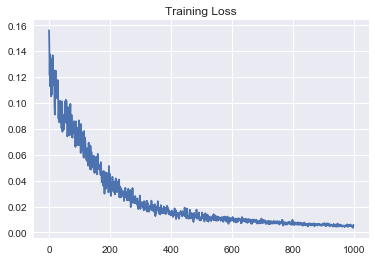

In [8]:
# 训练，使得决策面与高斯分布相似
lh = np.zeros(1000)
for i in range(1000):
    # Instead of sampling only from gaussian, want the domain to be covered as uniformly a
    # as possible
    d = (np.random.random(M)-0.5) * 10.0
    # d = np.random.normal(mu, sigma, M)
    labels = norm.pdf(d, loc=mu, scale=sigma)
    lh[i], _ = sess.run([loss, optimizer], {input_node: np.reshape(d, (M, 1)),
                                            train_labels: np.reshape(labels, (M, 1))})
plt.plot(lh)
plt.title("Training Loss")

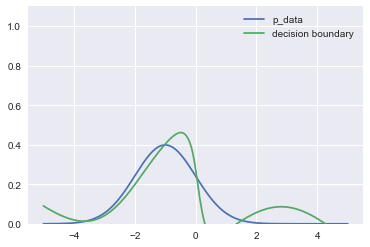

In [9]:
plot_d0(D, input_node)

In [10]:
# copy the learned weights over into a temporary array
weightsD = sess.run(theta)
sess.close()

# Build Net
Now to build the actual generative adversial network. 这里使用了TensorFlow中重用变量的特性：
- 首先定义了生成器
- 然后定义了鉴别器
- 鉴别器的网络使用了复用：`scope.reuse_variables()`
- 鉴别器一个连接生成器，一个连接数据

Goodfellow等人提出的算法是在训练k步鉴别器后训练生成器，最终使得整个模型收敛。

In [11]:
with tf.variable_scope("G"):
    z_node = tf.placeholder(tf.float32, shape=(M, 1))
    G, theta_g = mlp(z_node, 1)
    G = tf.multiply(5.0, G)
with tf.variable_scope("D") as scope:
    x_node = tf.placeholder(tf.float32, shape=(M, 1))
    fc, theta_d = mlp(x_node, 1)
    D1 = tf.maximum(tf.minimum(fc, .99), 0.01)
    # make a copy of D that uses the same variables, but takes in G as input
    scope.reuse_variables()
    fc, theta_d = mlp(G, 1)
    D2 = tf.maximum(tf.minimum(fc, .99), 0.01)
obj_d = tf.reduce_mean(tf.log(D1)+tf.log(1-D2))
obj_g = tf.reduce_mean(tf.log(D2))
# set up optimizer for G, D
opt_d = momentum_optimizer(1-obj_d, theta_d)
opt_g = momentum_optimizer(1-obj_g, theta_g)

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
# copy weights from pre-training over to new D network
for i, v in enumerate(theta_d):
    sess.run(v.assign(weightsD[i]))


def plot_fig():
    # plots pg, p_data, decision boundary
    f, ax = plt.subplots(1)
    # p_data
    xs = np.linspace(-5, 5, 1000)
    ax.plot(xs, norm.pdf(xs, loc=mu, scale=sigma), label='p_data')
    
    # decision boundary
    r = 5000
    xs = np.linspace(-5, 5, r)
    ds = np.zeros((r, 1))
    # process multiple points in parallel in same mini-batch
    for i in range(int(r/M)):
        x = np.reshape(xs[M*i: M*(i+1)], (M, 1))
        ds[M*i: M*(i+1)] = sess.run(D1, {x_node: x})
    ax.plot(xs, ds, label='decision boundary')
    
    # distribution of inverse-mapped points
    zs = np.linspace(-5, 5, r)
    gs = np.zeros((r, 1))
    for i in range(int(r/M)):
        z = np.reshape(zs[M*i: M*(i+1)], (M, 1))
        gs[M*i: M*(i+1)] = sess.run(G, {z_node: z})
    histc, edges = np.histogram(gs, bins=10)
    ax.plot(np.linspace(-5, 5, 10), histc/float(r), label='p_g')
    # ylim, legend
    ax.set_ylim(0, 1.1)
    plt.legend()

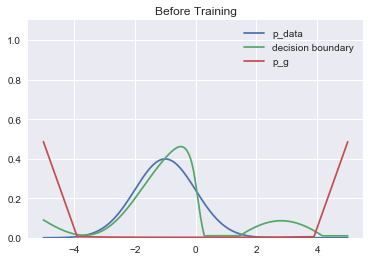

In [12]:
# initial conditions
plot_fig()
plt.title('Before Training')

In [13]:
# Algorithm of Goodfellow et al 2014
k = 1
histd, histg = np.zeros(TRAIN_ITERS), np.zeros(TRAIN_ITERS)
for i in range(TRAIN_ITERS):
    for j in range(k):
        x = np.random.normal(mu, sigma, M)
        x.sort()
        z = np.linspace(-5.0, 5.0, M) + np.random.random(M) * 0.01
        histd[i], _ = sess.run([obj_d, opt_d], {x_node: np.reshape(x, (M, 1)),
                                                z_node: np.reshape(z, (M, 1))})
    z = np.linspace(-5.0, 5.0, M) + np.random.random(M) * 0.01
    histg[i], _ = sess.run([obj_g, opt_g], {z_node: np.reshape(z, (M, 1))})
    if i % (TRAIN_ITERS//10) == 0:
        print(float(i)/float(TRAIN_ITERS))

0.0


0.1


0.2


0.3


0.4


0.5


0.6


0.7


0.8


0.9


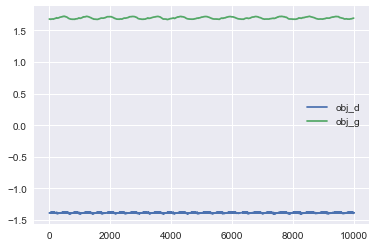

In [22]:
plt.plot(range(TRAIN_ITERS), histd, label='obj_d')
plt.plot(range(TRAIN_ITERS), 1-histg, label='obj_g')
plt.legend()

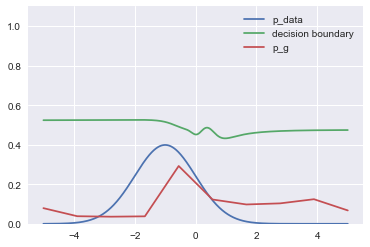

In [23]:
plot_fig()